In [1]:
import torch  
from torch import nn
import sys
sys.path.append('../') 
import utils as d2l

## 一、Model

In [46]:
class LeNet_(nn.Module):
    def __init__(self):
        super(LeNet_,self).__init__()
        self.conv_block1=nn.Sequential(nn.Conv2d(1,6,kernel_size=5,padding=2),nn.Sigmoid(),nn.AvgPool2d(kernel_size=2,stride=2))
        self.conv_block2=nn.Sequential(nn.Conv2d(6,16,kernel_size=5),nn.Sigmoid(),nn.AvgPool2d(kernel_size=2,stride=2))
        self.model=nn.Sequential(self.conv_block1,self.conv_block2,nn.Flatten(),
                                 nn.Linear(16*5*5,120),nn.Sigmoid(),
                                 nn.Linear(120,84),nn.Sigmoid(),
                                 nn.Linear(84,10))
    def forward(self,x):
        return self.model(x)

In [48]:
net=LeNet_()
net

LeNet_(
  (conv_block1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv_block2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): Sigmoid()
      (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (1): Sequential(
      (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
      (1): Sigmoid()
      (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=400, out_features=120, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=120, out_features=84, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [50]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)  
y=net(X)
y.shape

torch.Size([1, 10])

## 二、Train

In [53]:
batch_size = 256
#Load Data
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [63]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):  
    """用GPU训练模型(在第六章定义)"""
     # 使用 Xavier 初始化权重
    def init_weights(m):  
        if type(m) == nn.Linear or type(m) == nn.Conv2d:  
            nn.init.xavier_uniform_(m.weight) 
    net.apply(init_weights)  

    print('training on', device)  # 打印训练设备
    net.to(device)  # 将模型移动到指定设备 (GPU/CPU)

    optimizer = torch.optim.SGD(net.parameters(), lr=lr)  # 定义随机梯度下降优化器
    loss = nn.CrossEntropyLoss()  # 定义交叉熵损失函数，用于分类任务

    # 动画器：绘制训练损失、训练准确率和测试准确率的变化图
    animator = d2l.Animator(
        xlabel='epoch', xlim=[1, num_epochs], 
        legend=['train loss', 'train acc', 'test acc']
    )

    # 定义计时器和批次数量
    timer, num_batches = d2l.Timer(), len(train_iter)

    #train
    for epoch in range(num_epochs):  
        metric = d2l.Accumulator(3)  # 用于累加训练损失、准确率和样本数
        net.train()  # 设置模型为训练模式

        for i, (X, y) in enumerate(train_iter):  
            timer.start()  # 开始计时
            optimizer.zero_grad()  # 清除梯度

            # 将输入数据和标签移动到指定设备
            X, y = X.to(device), y.to(device)

            y_hat = net(X)  # 前向传播，计算预测值
            l = loss(y_hat, y)  # 计算损失
            l.backward()  # 反向传播
            optimizer.step()  # 更新参数

            # 无需计算梯度，累加损失和准确率
            with torch.no_grad():  
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])  
            timer.stop()  # 停止计时

            # 计算当前训练损失和准确率
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]

            # 每隔一定批次，更新动画器
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,  
                             (train_l, train_acc, None))

        # 每个 epoch 后测试模型并更新动画器
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)  
        animator.add(epoch + 1, (None, None, test_acc))  

        # 打印每个 epoch 的损失和准确率
        print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '  
              f'test acc {test_acc:.3f}')
    
    # 打印每秒处理的样本数
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '  
          f'on {str(device)}')

loss 0.474, train acc 0.823, test acc 0.795
59889.3 examples/sec on cuda:0


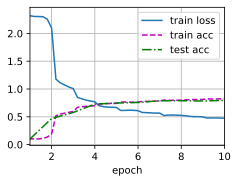

In [65]:
lr, num_epochs = 0.9, 10  
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())